In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os
import sys
from copy import deepcopy
from dataclasses import dataclass, field
from pathlib import Path
from typing import List, Optional, Literal, Tuple
from torch import Tensor

import cv2
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import torch
import tqdm

from einops import rearrange
from jaxtyping import Float, Int

from neural_jacobian_field.inference import (
    CameraConfig,
    ModelConfig,
    ProgramConfig,
    CameraContext,
    load_model_cfg,
    load_model,
    load_nerfstudio_data,
    parse_nerfstudio_camera,
    plotting,
)
from neural_jacobian_field.rendering.geometry import (
    get_world_rays_with_z,
    project_world_coords_to_camera,
)
from neural_jacobian_field.data.dataset.dataset_toy_arm import DatasetToyArmPointTrack

from neural_jacobian_field.visualization.view_interpolation import (
    interpolate_intrinsics,
    interpolate_pose,
    reproj_best_torch,
)
from PIL import Image

In [54]:
data_config_path = Path(
    "./inference_demo_data/config/toy_arm_config.json"
)

# TODO: modify cfg path and ckpt path appropriately.
args = ProgramConfig(
    ModelConfig(
        # note this is relative to the
        model_cfg_path=Path("../project/configurations/config"),
        model_ckpt_path=Path("../model_checkpoints/toy_arm/model.ckpt"),
    ),
    CameraConfig(
        ctxt_camera_idx=3,
        trgt_camera_idx=7,
        downscale_factor=1,
    ),
)

In [4]:
"""Load camera information"""

cameras, metadata = load_nerfstudio_data(
    data_path=data_config_path,
    downscale_factor=args.camera_config.downscale_factor,
)

camera_context = parse_nerfstudio_camera(
    cameras=cameras,
    ctxt_camera_idx=args.camera_config.ctxt_camera_idx,
    trgt_camera_idx=args.camera_config.trgt_camera_idx,
    device=args.device,
)
render_height = metadata["render_height"]
render_width = metadata["render_width"]

In [5]:
"""Load model"""

ROBOT_ACTION_DIMENSIONS = {
    "toy_arm": 6,
}
ROBOT_DATASET_CLASS = {"toy_arm": DatasetToyArmPointTrack}
ROBOT_TYPES = Literal["toy_arm", "allegro"]  # TODO: use enum

curr_robot_type: ROBOT_TYPES = "toy_arm"
curr_model_type = "jacobian"

action_dim = ROBOT_ACTION_DIMENSIONS[curr_robot_type]
robot_dataset_cls = ROBOT_DATASET_CLASS[curr_robot_type]

model_cfg = load_model_cfg(
    args.model_config.model_cfg_path,
    overrides=[
        f"model={curr_robot_type}",
        f"dataset={curr_robot_type}",
        f"model.action_model_type={curr_model_type}",
        f"model.action_dim={action_dim}",
        "model.train_encoder=False",
        "model.rendering.num_proposal_samples=[256]",
        "model.rendering.num_nerf_samples=256",
    ],
)

model = load_model(
    model_cfg=model_cfg,
    model_ckpt=args.model_config.model_ckpt_path,
    device=args.device,
)


z_near = torch.tensor([robot_dataset_cls.near], device=args.device)
z_far = torch.tensor([robot_dataset_cls.far], device=args.device)

/home/scene-rep-robot/miniconda3/envs/neural-jacobian-field/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Dropping parameter model.field.aabb
Dropping parameter model.proposal_networks.0.aabb


/home/scene-rep-robot/miniconda3/envs/neural-jacobian-field/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['model.field.jacobian_pred_head2.lin_in.weight', 'model.field.jacobian_pred_head2.lin_in.bias', 'model.field.jacobian_pred_head2.lin_out.weight', 'model.field.jacobian_pred_head2.lin_out.bias', 'model.field.jacobian_pred_head2.blocks.0.fc_0.weight', 'model.field.jacobian_pred_head2.blocks.0.fc_0.bias', 'model.field.jacobian_pred_head2.blocks.0.fc_1.weight', 'model.field.jacobian_pred_head2.blocks.0.fc_1.bias', 'model.field.jacobian_pred_head2.blocks.1.fc_0.weight', 'model.field.jacobian_pred_head2.blocks.1.fc_0.bias', 'model.field.jacobian_pred_head2.blocks.1.fc_1.weight', 'model.field.jacobian_pred_head2.blocks.1.fc_1.bias', 'model.field.jacobian_pred_head2.blocks.2.fc_0.weight', 'model.field.jacobian_pred_head2.blocks.2.fc_0.bias', 'model.field.jacobian_pred_head2.blocks.2.fc_1.weight', 'm

In [6]:
"""This part is tailor-made for visualizing the the chain-like structure of the toy robot"""

from einops import reduce

image_width, image_height = 640, 480


def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())


def denormalize_torch_image(img_tensor: torch.Tensor) -> np.ndarray:
    """
    Denormalize a [0, 1] torch image of shape [1, 3, H, W] to a numpy array of shape [H, W, 3]
    with values in the range [0, 255].

    Args:
        img_tensor (torch.Tensor): Input tensor image of shape [1, 3, H, W].

    Returns:
        np.ndarray: Denormalized image of shape [H, W, 3] with values in the range [0, 255].
    """
    # Denormalize
    img_numpy = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255.0
    # Convert to uint8
    img_numpy = img_numpy.astype(np.uint8)
    return img_numpy


def visualize_jacobian_chain_structure(
    input_image_np: Int[np.ndarray, "H W rgb"],
    input_joint_sensitivity_np: Float[Tensor, "action_dim H W"],
    joint_colors_np: Float[np.ndarray, "rgb action_dim"],
    debug: bool = False,
) -> Tuple[Int[np.ndarray, "H W rgb"], Int[np.ndarray, "H W rgb"]]:

    canvas_overlay = input_image_np.copy()

    list_of_diff_masks = []
    list_of_norm_projected = []

    for i in range(1, 5):
        prev_s = ((input_joint_sensitivity_np[i])).clip(0.08, 1.5)
        next_s = ((input_joint_sensitivity_np[i + 1])).clip(0.08, 1.5)
        diff = (prev_s - next_s).clip(0.01, 1)
        diff = normalize_image(diff)
        diff = cv2.resize(diff, (image_width, image_height))

        if debug:
            # create a 1x3 grid of plots
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            # draw
            ax[0].imshow(prev_s)
            ax[0].set_title("prev_s")
            ax[1].imshow(next_s)
            ax[1].set_title("next_s")
            ax[2].imshow(diff)
            ax[2].set_title("diff")
            fig.colorbar(ax[0].imshow(prev_s), ax=ax[0])
            fig.colorbar(ax[1].imshow(next_s), ax=ax[1])
            fig.colorbar(ax[2].imshow(diff), ax=ax[2])
            plt.show()

        projected = diff[..., None] * np.array(joint_colors_np[i])
        minima = reduce(projected, "C H W -> C () ()", "min")
        maxima = reduce(projected, "C H W -> C () ()", "max")

        norm_projected = (projected - minima) / (maxima - minima + 1e-10)
        norm_projected = (norm_projected * 255).clip(0, 255).astype(np.uint8)

        if debug:
            overlay = cv2.addWeighted(input_image_np, 0.5, norm_projected, 0.8, 0)
            plt.imshow(overlay)
            plt.show()

        list_of_diff_masks.append(diff)
        list_of_norm_projected.append(norm_projected)


    next_s = cv2.resize(next_s, (image_width, image_height))

    list_of_diff_masks.append(next_s.copy())
    next_s = normalize_image(next_s.clip(0.25, 1.0))

    projected = next_s[..., None] * np.array(joint_colors_np[i + 1])
    minima = reduce(projected, "C H W -> C () ()", "min")
    maxima = reduce(projected, "C H W -> C () ()", "max")

    norm_projected = (projected - minima) / (maxima - minima + 1e-10)
    norm_projected = (norm_projected * 255).clip(0, 255).astype(np.uint8)
    list_of_norm_projected.append(norm_projected)

    canvas_overlay = input_image_np.copy()
    canvas_overlay = cv2.cvtColor(canvas_overlay, cv2.COLOR_RGB2RGBA)
    canvas_overlay[..., 3] = 155
    canvas_overlay = Image.fromarray(canvas_overlay)

    canvas_white_bkgd = np.ones_like(input_image_np, dtype=np.uint8) * 255
    canvas_white_bkgd = cv2.cvtColor(canvas_white_bkgd, cv2.COLOR_RGB2RGBA)

    canvas_white_bkgd[..., 3] = 255
    canvas_white_bkgd = Image.fromarray(canvas_white_bkgd)

    for i in range(len(list_of_norm_projected)):
        norm_projected_rgba = cv2.cvtColor(
            list_of_norm_projected[i], cv2.COLOR_RGB2RGBA
        )
        diff = list_of_diff_masks[i]
        diff = normalize_image(diff)

        alpha_mask = diff * 1.5
        alpha_mask = (alpha_mask.clip(0, 1) * 255).astype(np.uint8)
        norm_projected_rgba[..., 3] = alpha_mask

        overlay = Image.fromarray(norm_projected_rgba)

        canvas_overlay.paste(overlay, (0, 0), overlay)
        canvas_white_bkgd.paste(overlay, (0, 0), overlay)

    return np.asarray(canvas_overlay), np.asarray(canvas_white_bkgd)

In [7]:
def render_single_view(
    input_image_th: Float[Tensor, "1 channel height width"],
    input_action_th: Float[Tensor, "1 dim"],
    input_camera_context: CameraContext,
    joint_colors_th: Float[Tensor, "rgb action_dim"],
    trgt_ros: Optional[Float[Tensor, "1 ray 3"]] = None,
    trgt_rds: Optional[Float[Tensor, "1 ray 3"]] = None,
    patch_size: int = 2048,
    compute_action_features: bool = True,
    zero_out_sensitivity_below_thresh: float = 0.0,
    zero_out_sensitivity_below_depth_percentile: int = 999,
    device: torch.device = torch.device("cuda:0"),
    verbose: bool = True,
):

    trgt_extrinsics = input_camera_context["trgt_c2w"].to(device).unsqueeze(0)
    ctxt_extrinsics = input_camera_context["ctxt_c2w"].to(device).unsqueeze(0)

    trgt_intrinsics = input_camera_context["trgt_intr"].to(device).unsqueeze(0)
    ctxt_intrinsics = input_camera_context["ctxt_intr"].to(device).unsqueeze(0)

    coordinates = input_camera_context["coordinates"].to(device)
    coordinates = input_camera_context["coordinates"].view(-1, 2).unsqueeze(0)

    if trgt_ros is None and trgt_rds is None:
        trgt_ros, trgt_rds, _ = get_world_rays_with_z(
            coordinates, trgt_intrinsics, trgt_extrinsics
        )


    model_outputs = model.patch_render(
        ctxt_image=input_image_th,
        robot_action=input_action_th,
        origins=trgt_ros,
        directions=trgt_rds,
        ctxt_c2w=ctxt_extrinsics,
        ctxt_intr=ctxt_intrinsics,
        trgt_c2w=trgt_extrinsics,
        trgt_intr=trgt_intrinsics,
        z_near=z_near,
        z_far=z_far,
        patch_size=patch_size,
        render_height=render_height,
        render_width=render_width,
        compute_action_features=compute_action_features,
        verbose=verbose,
    )

    joint_sensitivity_th = plotting.compute_joint_sensitivity(
        model_outputs["pred_feat"].squeeze(0),
        camera_context["ctxt_c2w"],
    )

    if zero_out_sensitivity_below_thresh > 0.0:
        joint_sensitivity_th[
            joint_sensitivity_th < zero_out_sensitivity_below_thresh
        ] = 0

    if zero_out_sensitivity_below_depth_percentile != 999:
        depth_original = model_outputs["pred_depth"].squeeze(0).cpu().numpy()
        # create binary mask using the prescribed threshold
        depth_thresh = np.percentile(
            depth_original, zero_out_sensitivity_below_depth_percentile
        )
        depth_mask = (depth_original > depth_thresh).squeeze(-1)
        joint_sensitivity_th[:, depth_mask] = 0

    if curr_robot_type == "toy_arm":
        input_image_np = denormalize_torch_image(input_image_th)
        pred_jacobian_overlay_rgb, pred_jacobian_rgb = visualize_jacobian_chain_structure(
            input_image_np=input_image_np,
            input_joint_sensitivity_np=joint_sensitivity_th.cpu().numpy(),
            joint_colors_np=joint_colors_th.T.cpu().numpy(),
        )
        model_outputs["pred_jacobian_overlay_rgb"] = pred_jacobian_overlay_rgb

    else:
        pred_jacobian_rgb = plotting.visualize_joint_sensitivity(
            joint_sensitivity_th=joint_sensitivity_th,
            joint_colors_th=joint_colors_th,
        )

    model_outputs["joint_sensitivity"] = joint_sensitivity_th
    model_outputs["pred_jacobian_rgb"] = pred_jacobian_rgb

    return model_outputs

In [8]:
def render_interpolated_view(
    input_image: Float[Tensor, "() channel height width"],
    input_action: Float[Tensor, "() dim"],
    input_camera_context: CameraContext,
    joint_colors_th: Float[Tensor, "rgb action_dim"],
    src_steps: Tensor,
    src_weights: Tensor,
    list_of_drawing_loc_x: List[Tensor],
    list_of_drawing_loc_y: List[Tensor],
    list_of_ray_positions: List[Tensor],
    list_of_ray_positions_warped: List[Tensor],
    patch_size: int = 2048,
    zero_out_sensitivity_below_thresh: float = 0.0,
    zero_out_sensitivity_below_depth_percentile: int = 999,
    num_frames_to_interpolate: int = 30,
    # flow parameters
    flow_vector_length_multiplier: int = 50,
    flow_vector_line_thickness: int = 3,
    # misc
    device: torch.device = torch.device("cuda:0"),
    verbose: bool = True,
):

    trgt_extrinsics = input_camera_context["trgt_c2w"].to(device)
    ctxt_extrinsics = input_camera_context["ctxt_c2w"].to(device)

    trgt_intrinsics = input_camera_context["trgt_intr"].to(device)
    ctxt_intrinsics = input_camera_context["ctxt_intr"].to(device)

    trgt_intrinsics_raw = input_camera_context["trgt_intr_raw"].to(device)
    ctxt_intrinsics_raw = input_camera_context["ctxt_intr_raw"].to(device)

    coordinates = input_camera_context["coordinates"].to(device)
    coordinates = input_camera_context["coordinates"].view(-1, 2)[None]

    output_video_dict = {
        k: []
        for k in (
            "pred_rgb",
            "pred_depth_rgb",
            "pred_jacobian_rgb",
            "pred_flow_rgb",
            "pred_arrow_rgb",
        )
    }
    output_video_dict["pred_arrow_rgb"] = [
        [] for _ in range(len(list_of_drawing_loc_x))
    ]

    for t in tqdm.tqdm(
        torch.linspace(0, 1, num_frames_to_interpolate), desc="Rendering video frames"
    ):
        # Apply smoothing.
        t = (math.cos(math.pi * (t.item() + 1)) + 1) / 2

        # Video validation always uses a batch size of 1.
        interp_trgt_c2w = interpolate_pose(
            trgt_extrinsics,
            ctxt_extrinsics,
            t,
        )[None]

        interp_trgt_intr = interpolate_intrinsics(
            trgt_intrinsics,
            ctxt_intrinsics,
            t,
        )[None]

        interp_trgt_intr_raw = interpolate_intrinsics(
            trgt_intrinsics_raw,
            ctxt_intrinsics_raw,
            t,
        )[None]

        origins, directions, _ = get_world_rays_with_z(
            coordinates, interp_trgt_intr, interp_trgt_c2w
        )

        xy_B_map_for_t = reproj_best_torch(
            src_steps=src_steps,
            src_weights=src_weights,
            src_c2w=ctxt_extrinsics,
            tgt_c2w=interp_trgt_c2w[0],
            src_intrinsics=ctxt_intrinsics_raw,
            tgt_intrinsics=interp_trgt_intr_raw[0],
        )

        with torch.no_grad():

            total_pred_outputs = render_single_view(
                input_image_th=input_image,
                input_action_th=input_action,
                input_camera_context=input_camera_context,
                joint_colors_th=joint_colors_th,
                trgt_ros=origins,
                trgt_rds=directions,
                compute_action_features=True,
                zero_out_sensitivity_below_thresh=zero_out_sensitivity_below_thresh,
                zero_out_sensitivity_below_depth_percentile=zero_out_sensitivity_below_depth_percentile,
                patch_size=patch_size,
                device=device,
                verbose=verbose,
            )

            pred_rgb = total_pred_outputs["pred_rgb"].cpu().numpy()[0]
            pred_flow_rgb = total_pred_outputs["pred_flow_rgb"].cpu().numpy()[0]
            pred_depth_rgb = total_pred_outputs["pred_depth_rgb"].cpu().numpy()[0]
            pred_jacobian_rgb = total_pred_outputs["pred_jacobian_rgb"]

            output_video_dict["pred_rgb"].append(pred_rgb)
            output_video_dict["pred_flow_rgb"].append(pred_flow_rgb)
            output_video_dict["pred_depth_rgb"].append(pred_depth_rgb)
            output_video_dict["pred_jacobian_rgb"].append(pred_jacobian_rgb)

            for item_idx in range(len(list_of_drawing_loc_x)):
                drawing_loc_x = list_of_drawing_loc_x[item_idx]
                drawing_loc_y = list_of_drawing_loc_y[item_idx]
                ray_positions = list_of_ray_positions[item_idx]
                ray_positions_warped = list_of_ray_positions_warped[item_idx]

                pix_to_draw_x, pix_to_draw_y = xy_B_map_for_t[
                    drawing_loc_y, drawing_loc_x
                ].split(1, dim=-1)

                uv = project_world_coords_to_camera(
                    ray_positions, interp_trgt_c2w, interp_trgt_intr_raw
                )
                uv_warped = project_world_coords_to_camera(
                    ray_positions_warped, interp_trgt_c2w, interp_trgt_intr_raw
                )

                optical_flow_projected = uv_warped - uv

                flow_arrow_rgb = plotting.draw_flow_on_image(
                    curr_frame=pred_jacobian_rgb[..., :3].copy(),
                    pix_to_draw_y=pix_to_draw_y,
                    pix_to_draw_x=pix_to_draw_x,
                    flow_pred_combined=optical_flow_projected,
                    color_map_choice="cool",
                    length_multiplier=flow_vector_length_multiplier,
                    line_thickness=flow_vector_line_thickness,
                    use_norm=True,
                )

                output_video_dict["pred_arrow_rgb"][item_idx].append(flow_arrow_rgb)

    # if list_of_drawing_loc_x is not None:

    output_video_dict["pred_arrow_rgb"] = [
        np.stack(x, axis=0) for x in output_video_dict["pred_arrow_rgb"]
    ]

    for key in ("pred_rgb", "pred_depth_rgb", "pred_flow_rgb", "pred_jacobian_rgb"):
        output_video_dict[key] = np.stack(output_video_dict[key], axis=0)  # type: ignore

    return output_video_dict

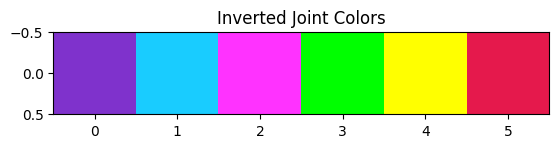

In [10]:
# Define joint colors
joint_colors_np = [
    [0.5, 0.8, 0.2],
    [0.9, 0.2, 0.0],
    [0, 0.8, 0],
    [1.0, 0.0, 1.0],
    [0, 0, 1],
    [0.1, 0.9, 0.7],
]

# Invert joint colors
joint_colors_np = 1 - np.array(joint_colors_np)

# Display the joint colors
plt.imshow(np.array([joint_colors_np]))
plt.title("Inverted Joint Colors")
plt.show()

# Convert to torch tensor and move to the specified device
joint_colors_th = torch.tensor(joint_colors_np).T.to(args.device).float()

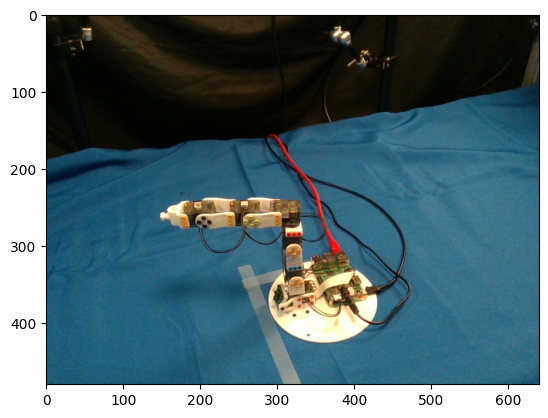

In [19]:
"""Load some data and start inference"""
from neural_jacobian_field.utils.io import numpy_to_torch_image
from neural_jacobian_field.utils import convention

input_image_np = cv2.imread("./inference_demo_data/toy_arm_observation.png")
input_image_np[:] = input_image_np[..., ::-1]
input_image_th = numpy_to_torch_image(input_image_np).to(args.device)

plt.imshow(input_image_np)
plt.show()


In [20]:
### We are reloading cameras to make trgt = ctxt
camera_context = parse_nerfstudio_camera(
    cameras=cameras,
    ctxt_camera_idx=args.camera_config.ctxt_camera_idx,
    trgt_camera_idx=args.camera_config.ctxt_camera_idx,
    device=args.device,
)

 61%|██████    | 91/150 [00:09<00:06,  9.57it/s]

100%|██████████| 150/150 [00:15<00:00,  9.58it/s]


,

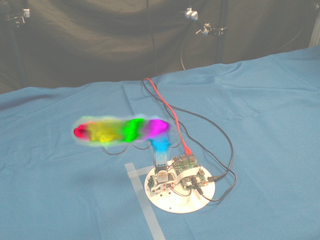
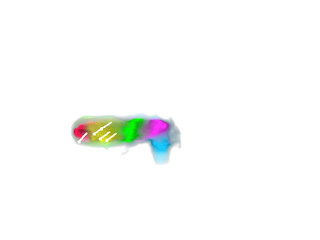

100%|██████████| 150/150 [00:15<00:00,  9.58it/s]


,

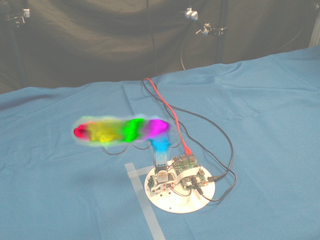
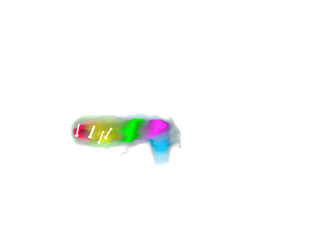

100%|██████████| 150/150 [00:15<00:00,  9.58it/s]


,

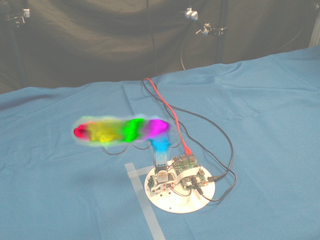
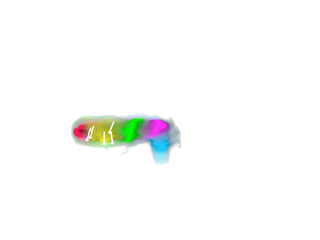

100%|██████████| 150/150 [00:15<00:00,  9.58it/s]


,

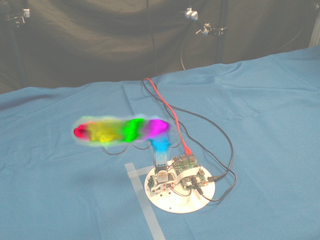
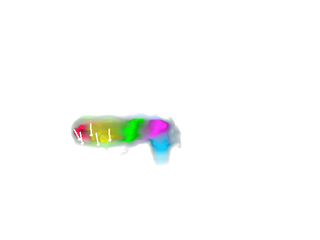

100%|██████████| 150/150 [00:15<00:00,  9.57it/s]


,

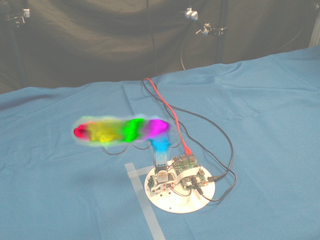
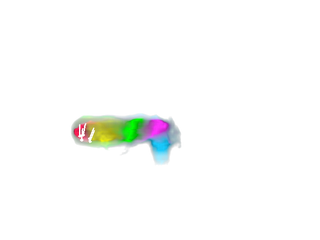

In [40]:
### We are reloading cameras to make trgt = ctxt
camera_context = parse_nerfstudio_camera(
    cameras=cameras,
    ctxt_camera_idx=args.camera_config.ctxt_camera_idx,
    trgt_camera_idx=args.camera_config.ctxt_camera_idx,
    device=args.device,
)

list_of_drawing_loc_x = []
list_of_drawing_loc_y = []
list_of_ray_positions = []
list_of_ray_positons_warped = []

num_arrows_to_draw = 5
for joint_activation_idx in range(1, 6):
    flow_mask_thresh = 0.40

    input_action_place_holder_th = torch.zeros((1, action_dim)).to(args.device)
    input_action_place_holder_th[:, joint_activation_idx] = 1.0

    input_image_th = numpy_to_torch_image(input_image_np).unsqueeze(0).to(args.device)

    ctxt_extrinsics = camera_context["ctxt_c2w"].to(args.device)
    trgt_extrinsics = ctxt_extrinsics.clone()

    ctxt_intrinsics = camera_context["ctxt_intr"].to(args.device)
    trgt_intrinsics = camera_context["trgt_intr"].to(args.device)

    coordinates = camera_context["coordinates"].to(args.device)
    coordinates = camera_context["coordinates"].view(-1, 2)

    trgt_ros, trgt_rds, _ = get_world_rays_with_z(
        coordinates[None], trgt_intrinsics[None], trgt_extrinsics[None]
    )

    model_outputs = render_single_view(
        input_image_th=input_image_th,
        input_action_th=input_action_place_holder_th,
        input_camera_context=camera_context,
        joint_colors_th=joint_colors_th,
        trgt_ros=trgt_ros,
        trgt_rds=trgt_rds,
        patch_size=2048,
        compute_action_features=True,
        zero_out_sensitivity_below_depth_percentile=90,
    )

    joint_sensitivity_th = model_outputs["joint_sensitivity"]
    pred_jacobian_overlay_rgb = model_outputs["pred_jacobian_overlay_rgb"]

    normalized_flow = torch.norm(model_outputs["pred_flow"], dim=1, p=2, keepdim=True)
    adaptive_thresh = (normalized_flow.max() * flow_mask_thresh).item()
    flow_mask = (normalized_flow > adaptive_thresh).cpu().numpy().squeeze()
    # get indices that are true
    sensitivity_mask = joint_sensitivity_th.mean(0).cpu().numpy() > flow_mask_thresh
    flow_mask *= sensitivity_mask

    # apply filtering
    drawing_loc_y, drawing_loc_x = flow_mask.nonzero()
    indices = np.arange(len(drawing_loc_y))

    rand_indices = np.random.choice(indices, num_arrows_to_draw, replace=False)

    # rand_indices = np.random.choice(len(drawing_loc_y), num_to_draw, replace=False)
    drawing_loc_y = drawing_loc_y[rand_indices]
    drawing_loc_x = drawing_loc_x[rand_indices]
    # break

    ray_positions = (
        model_outputs["pred_ray_positions"]
        .clone()[0, :, drawing_loc_y, drawing_loc_x]
        .T
    )
    ray_positions_warped = (
        model_outputs["pred_ray_positions_warped"]
        .clone()[0, :, drawing_loc_y, drawing_loc_x]
        .T
    )
    trgt_intrinsics_raw = camera_context["trgt_intr_raw"].to(args.device).unsqueeze(0)
    ctxt_intrinsics_raw = camera_context["ctxt_intr_raw"].to(args.device).unsqueeze(0)
    ctxt_intrinsics = camera_context["ctxt_intr"].to(args.device).unsqueeze(0)
    ctxt_extrinsics = camera_context["ctxt_c2w"].to(args.device).unsqueeze(0)

    uv = project_world_coords_to_camera(
        ray_positions, ctxt_extrinsics, ctxt_intrinsics_raw
    )
    uv_warped = project_world_coords_to_camera(
        ray_positions_warped, ctxt_extrinsics, ctxt_intrinsics_raw
    )
    optical_flow = uv_warped - uv

    flow_arrow_drawn_on_jacobian = model_outputs["pred_jacobian_rgb"].copy()
    flow_arrow_drawn_on_jacobian = plotting.draw_flow_on_image(
        flow_arrow_drawn_on_jacobian,
        pix_to_draw_y=drawing_loc_y,
        pix_to_draw_x=drawing_loc_x,
        flow_pred_combined=optical_flow,
        line_thickness=2,
        length_multiplier=25,
        use_norm=True
    )

    media.show_images(
        [pred_jacobian_overlay_rgb, flow_arrow_drawn_on_jacobian],
        height=render_height // 2,
        width=render_width // 2,
    )

    list_of_drawing_loc_x.append(drawing_loc_x)
    list_of_drawing_loc_y.append(drawing_loc_y)
    list_of_ray_positions.append(ray_positions)
    list_of_ray_positons_warped.append(ray_positions_warped)
    


In [41]:
### We are reloading cameras to make trgt != ctxt
camera_context = parse_nerfstudio_camera(
    cameras=cameras,
    ctxt_camera_idx=args.camera_config.ctxt_camera_idx,
    trgt_camera_idx=args.camera_config.trgt_camera_idx,
    device=args.device,
)

src_steps_t0 = rearrange(model_outputs["pred_steps"], "() C H W -> H W C")
src_weights_t0 = rearrange(model_outputs["pred_weights"], "() C H W -> H W C")

output_video_dict = render_interpolated_view(
    input_image=input_image_th,
    input_action=input_action_place_holder_th,
    input_camera_context=camera_context,
    joint_colors_th=joint_colors_th,
    src_steps=src_steps_t0,
    src_weights=src_weights_t0,
    list_of_drawing_loc_x=list_of_drawing_loc_x,
    list_of_drawing_loc_y=list_of_drawing_loc_y,
    list_of_ray_positions=list_of_ray_positions,
    list_of_ray_positions_warped=list_of_ray_positons_warped,
    verbose=True,
)

Rendering video frames:   0%|          | 0/30 [00:00<?, ?it/s]

Rendering video frames: 100%|██████████| 30/30 [08:01<00:00, 16.03s/it]


In [46]:
from einops import pack

video_outputs = {}

for k, v in output_video_dict.items(): 
    if ("arrow" not in k ):
        video_outputs[k] = pack([v[::-1], v], "* h w c")[0]
    else:
        video_list = []
        for each_video in v:
            video_list.append(pack([each_video[::-1], each_video], "* h w c")[0])
        
        video_outputs[k] = video_list

In [51]:
# TODO: fix bug (due to refactoring) with flow visualizaiton
media.show_videos(
    [video_outputs["pred_depth_rgb"], video_outputs["pred_jacobian_rgb"][..., :3]],
    fps=30,
)

In [53]:
media.show_video(video_outputs["pred_arrow_rgb"][0], fps=30)